In [1]:
!pip install --upgrade pip
!pip install --upgrade allennlp
!pip install transformers==4.3.0

     |████████████████████████████████| 585 kB 868 kB/s 
  Attempting uninstall: allennlp
    Found existing installation: allennlp 2.0.1
    Uninstalling allennlp-2.0.1:
      Successfully uninstalled allennlp-2.0.1
     |████████████████████████████████| 1.8 MB 867 kB/s 
     |████████████████████████████████| 3.2 MB 4.6 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.4
    Uninstalling tokenizers-0.9.4:
      Successfully uninstalled tokenizers-0.9.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.2.2
    Uninstalling transformers-4.2.2:
      Successfully uninstalled transformers-4.2.2


In [2]:
!pip install datasets #to load xnli and mnli datasets from huggingface library
# !pip install google_trans_new
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 181 kB 862 kB/s 
     |████████████████████████████████| 69 kB 2.7 MB/s 
     |████████████████████████████████| 243 kB 3.9 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.55.1
    Uninstalling tqdm-4.55.1:
      Successfully uninstalled tqdm-4.55.1
     |████████████████████████████████| 55 kB 534 kB/s 
     |████████████████████████████████| 994 kB 1.2 MB/s 
     |████████████████████████████████| 42 kB 749 kB/s 
     |████████████████████████████████| 65 kB 1.5 MB/s 
     |████████████████████████████████| 53 kB 1.1 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=760ab29ded2ff0693fe8a32645eb969aa43d6e4ee1e5ae33fe29ffecbd363cca
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
import os.path
from os import path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/back-translations/back_translated.csv
/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [4]:
os.environ["WANDB_API_KEY"] = "0" # to silence warning

In [5]:
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import (XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel)            

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Dropout, Dense

from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from datasets import load_dataset, list_datasets
from tqdm import tqdm

from googletrans import Translator
# from google_trans_new import google_translator 

import time

# Resets all state generated by Keras
K.clear_session()

# For reproducibility
np.random.seed(0)

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Found TPU: ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Found TPU:  grpc://10.0.0.2:8470
Number of replicas: 8


In [7]:
train_df = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_df = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [8]:
# Stratify ensures that each sub-set contains approximately the same percentage of samples of each target class as the original set.
train_df, validation_df = train_test_split(train_df, stratify=train_df.label.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)

In [9]:
# check the number of rows and columns in the subsets after split
print("Train data shape after split: {} \n".format(train_df.shape))

print("Validation data shape after split: {} \n".format(validation_df.shape))

Train data shape after split: (9696, 6) 

Validation data shape after split: (2424, 6) 



In [10]:
# Configuration Settings

EPOCHS = 5
# BATCH_SIZE = 64
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 120
PATIENCE = 1
LEARNING_RATE = 1e-5
LOAD_XNLI = True
LOAD_MNLI = True
BACK_TRANSLATE = True
BT_FILEPATH = '../input/back-translations/back_translated.csv' #csv file containing the back translations of input training data

In [11]:
def process_xnli_data(test_df, all_keys=False):   
    if all_keys:
        split = 'train+validation+test'
    else:
        split = 'validation+test'
    
    print("Loading XNLI data...")
    
    dataset = load_dataset('xnli', 'all_languages', split=split) #returns a Dataset object  
    print(dataset)
    
    entries = []   
    for entry in tqdm(dataset): 
        hypothesis_langs = entry['hypothesis']['language'] #list of 15 lang string values
        hypothesis_values = entry['hypothesis']['translation'] #list of 15 hypothesis string values

        premise_langs = list(entry['premise'].keys()) #list of 15 lang string values
        premise_values = list(entry['premise'].values()) #list of 15 premise string values

        labels = [entry['label']]*len(hypothesis_langs) #all 15 languages for the same example have same label 

        if premise_langs == hypothesis_langs: #the languages in premise and hypothesis are in same order
#             values = list(zip(premise_values, hypothesis_values, hypothesis_langs, labels))
            values = list(zip(premise_values, hypothesis_values, labels))
            entries += values

#     xnli_df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'lang_abv', 'label']) #create dataframe for each key
    xnli_df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'label']) #create dataframe for each key
    
    # Get the number of missing data points per column
    missing_values_xnli = xnli_df.isnull().sum() 

    print("Number of missing data points per column in XNLI corpus:")
    print (missing_values_xnli)

    # Drop the missing value rows
    xnli_df.dropna(axis=0, inplace=True)
    print("Total number of data examples in XNLI corpus after dropping NA values: {}".format(xnli_df.shape[0]))
    
    ################## Delete duplicate rows between test_df and xnli_df in xnli corpus #########################
    xnli_df = xnli_df.drop_duplicates() #drop duplicate rows
    print('Total number of data examples in XNLI corpus after dropping duplicate values: {}'.format(xnli_df.shape[0]))
    
    print('Test data shape: {}'.format(test_df.shape))
    test_df = test_df.drop_duplicates() #drop duplicate rows
    print('Test data shape after dropping duplicate rows: {}'.format(test_df.shape))

    df_merge = pd.merge(xnli_df, test_df, on=['premise','hypothesis'], how='inner')
    xnli_df = xnli_df.append(df_merge, ignore_index=True) 

    xnli_df['duplicated'] = xnli_df.duplicated(subset=['premise','hypothesis'], keep=False) # keep=False marks the duplicated row with a True
    xnli_df = xnli_df[~xnli_df['duplicated']] # selects only rows which are not duplicated.
    
    xnli_df.drop(['duplicated', 'id', 'lang_abv', 'language'], axis = 1, inplace=True) # remove following columns
    ################## Delete duplicate rows between test_df and xnli_df in xnli corpus #########################
    
    print("XNLI corpus shape: {}".format(xnli_df.shape))
    
    del dataset #free up space
    
    return xnli_df

In [12]:
def process_mnli_data(validation=False):
    if validation:
        keys = ['train', 'validation_matched', 'validation_mismatched']
    else:
        keys = ['train']
    
    dataset = load_dataset('glue', name='mnli') #returns a DatasetDict object
    print(dataset)
    
    df_dict = {}
    
    for key in tqdm(keys):
        print("Processing MNLI {} data...".format(key))
        
        hypothesis = dataset[key]['hypothesis']
        premise = dataset[key]['premise']
        labels = dataset[key]['label']
        
        entries = list(zip(premise, hypothesis, labels))
        
        df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'label']) #create dataframe for each key
        df_dict[key] = df
        
    if validation:
        mnli_df = pd.concat([df_dict['train'], df_dict['validation_matched'], df_dict['validation_mismatched']], ignore_index=True)
    else:
        mnli_df = df_dict['train']
    
    # Get the number of missing data points per column
    missing_values_mnli = mnli_df.isnull().sum() 

    print("Number of missing data points per column in MNLI corpus:")
    print (missing_values_mnli)

    # Drop the missing value rows from training set
    mnli_df.dropna(axis=0, inplace=True)
    print("Total number of data examples in MNLI corpus after dropping NA values: {}\n".format(mnli_df.shape[0]))
    
    del dataset #free up space
    
    return mnli_df

In [13]:
def back_translate(train_df, target_lang='fr', sample=True, num_samples_per_lang=1000):
    if sample: #sample input training data to back translate
        train_df = train_df.groupby('language', group_keys=False).apply(lambda x: x.sample(min(len(x), num_samples_per_lang))).reset_index(drop=True)  

    df_list = []
    limit_before_timeout = 100
    timeout = 5
    
    translator = Translator() 
    
    # Add functions to back translate input sentences
    def target_translate(x, target_lang):
        translation = translator.translate(x, dest=target_lang)
        return translation.text
    def source_translate(x, source_lang):
        translation = translator.translate(x, dest=source_lang) 
        return translation.text 
    
    for i in tqdm(range(len(train_df))):
        entry = train_df.loc[[i]]
        source_lang = entry.lang_abv.values.tolist()[0]
        if source_lang == 'zh':
            #print(googletrans.LANGUAGES) 
            source_lang = 'zh-cn' #'zh' not in googletrans.LANGUAGES        
        if (i!=0) and (i%limit_before_timeout == 0): #apply timeout after every 100 iterations 
            print('Iteration {} of {}'.format(i, len(train_df)))
            time.sleep(timeout)      
        # Back translate premise sentence
        entry['premise'] = entry['premise'].apply(lambda x: target_translate(x, target_lang))
#         time.sleep(0.2)
        entry['premise'] = entry['premise'].apply(lambda x: source_translate(x, source_lang))
#         time.sleep(0.2)       
        # Back translate hypothesis sentence
        entry['hypothesis'] = entry['hypothesis'].apply(lambda x: target_translate(x, target_lang))
#         time.sleep(0.2)
        entry['hypothesis'] = entry['hypothesis'].apply(lambda x: source_translate(x, source_lang))
#         time.sleep(0.2)
        df_list.append(entry)
    
    train_bt = pd.concat(df_list, ignore_index=True)
    print("Shape of back-translated training data: {}".format(train_bt.shape))
    return train_bt

In [14]:
def augment_data(df, use_xnli=True, use_mnli=True, use_bt=True, bt_filepath=''):
    df_list = [] 
    
    if use_bt:
        if path.exists(bt_filepath):
            bt_df = pd.read_csv(bt_filepath)
            print("Shape of back-translated training data: {}".format(bt_df.shape))
        else:
            bt_df = back_translate(df)
        bt_df = bt_df.drop(['id', 'lang_abv', 'language'], axis=1)
        df_list.append(bt_df)
        del bt_df #free up space 
    if use_xnli:
        xnli_df = process_xnli_data(test_df, all_keys=False)
        df_list.append(xnli_df)
        del xnli_df #free up space 
    if use_mnli:
        mnli_df = process_mnli_data(validation=True)
        df_list.append(mnli_df)
        del mnli_df #free up space
        
    train_df = df.drop(['id', 'lang_abv', 'language'], axis=1)
    
    if len(df_list) > 0: #augment data
        augmented_df = pd.concat(df_list, ignore_index=True)
        train_df = train_df.append(augmented_df, ignore_index=True) 
        
    train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle data
    print("Augmented data shape before removing duplicate rows: {}".format(train_df.shape))
    train_df.drop_duplicates(inplace=True) #drop duplicate rows
    print("Augmented data shape after removing duplicate rows: {}".format(train_df.shape))
    return train_df




train_df = augment_data(train_df, LOAD_XNLI, LOAD_MNLI, BACK_TRANSLATE, BT_FILEPATH) 
train_df.head(100)

Shape of back-translated training data: (5180, 6)
Loading XNLI data...


  7%|▋         | 537/7500 [00:00<00:01, 5366.84it/s]

Dataset xnli downloaded and prepared to /root/.cache/huggingface/datasets/xnli/all_languages/1.1.0/51ba3a1091acf33fd7c2a54bcbeeee1b1df3ecb127fdca003d31968fa3a1e6a8. Subsequent calls will reuse this data.
Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 7500
})


100%|██████████| 7500/7500 [00:01<00:00, 5197.65it/s]


Number of missing data points per column in XNLI corpus:
premise       0
hypothesis    0
label         0
dtype: int64
Total number of data examples in XNLI corpus after dropping NA values: 112500
Total number of data examples in XNLI corpus after dropping duplicate values: 112500
Test data shape: (5195, 5)
Test data shape after dropping duplicate rows: (5195, 5)
XNLI corpus shape: (110226, 3)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
Processing MNLI train data...


100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Processing MNLI validation_matched data...
Processing MNLI validation_mismatched data...
Number of missing data points per column in MNLI corpus:
premise       0
hypothesis    0
label         0
dtype: int64
Total number of data examples in MNLI corpus after dropping NA values: 412349

Augmented data shape before removing duplicate rows: (537451, 3)
Augmented data shape after removing duplicate rows: (522580, 3)


,premise,hypothesis,label
0,"It's true that once an inspection is demanded,...",Iran would be able to stall after an inspectio...,0
1,yeah i i have to do that i want to make some f...,I hate flowers so I don't think I would ever m...,2
2,"Splendidly housed in the H??tel Sal??, a beaut...",The man's portrait can no longer be found.,2
3,..شخص تكون فخورًا بأنك جزءًا منه وتدعمه؟,هل ترغب في الحصول على دعم عضو؟,0
4,شرکت کنندگان کو پراسپیکٹس کا نام‏، پتہ اور ٹیل...,شرکاء کو ممکنات سے رابطہ کرنے کی تفصیلات اور پ...,0
...,...,...,...
95,These were meant to be carried in the palm of ...,The mouth was repainted and the nose was dusted.,0
96,Etwa 1.400 Jahre vor der Errichtung des Palast...,Milreu war außer Landes.,0
97,Leave Parikia behind and Paroseas a number of ...,The villages are inhabited by the indigenous p...,1
98,"What's more, it's cheap.","In addition, it is very affordable.",0


In [15]:
# check the number of rows and columns in the augmented train data
print("Augmented train data shape: {}".format(train_df.shape))

Augmented train data shape: (522580, 3)


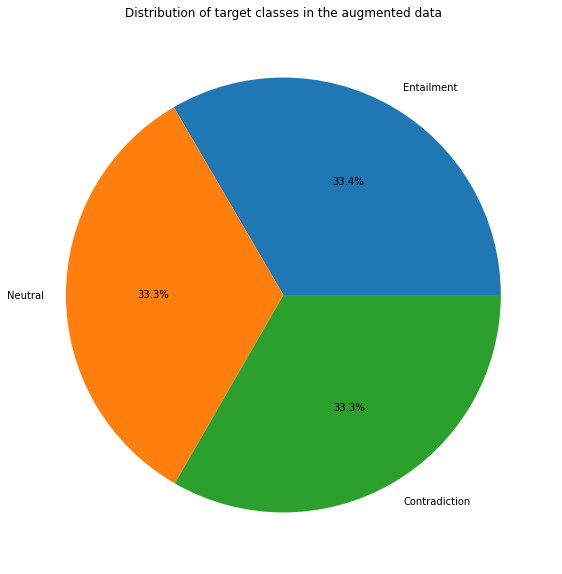

In [16]:
# check distribution of target classes in the augmented data
counts = train_df['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.title("Distribution of target classes in the augmented data")
plt.show()

In [17]:
PRETRAINED_MODEL_TYPES = {
    'xlmroberta': (XLMRobertaConfig, TFXLMRobertaModel, XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-large')
}

config_class, model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['xlmroberta']

In [18]:
# Download vocabulary from huggingface.co and cache.
# tokenizer = tokenizer_class.from_pretrained(model_name) 
tokenizer = AutoTokenizer.from_pretrained(model_name) #fast tokenizer

tokenizer

PreTrainedTokenizerFast(name_or_path='jplu/tf-xlm-roberta-large', vocab_size=250002, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [19]:
tokenizer.vocab_size

250002

In [20]:
def encode(df, tokenizer, max_len=50):
    
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True)
    print ("Complete")
    
    input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]
    
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask}    
    
    return inputs

In [21]:
train_input = encode(train_df, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [22]:
train_input['input_word_ids'].shape #[num_examples, max_len]
train_input['input_mask'].shape #[num_examples, max_len]

TensorShape([522580, 120])

In [23]:
validation_input = encode(validation_df, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [24]:
validation_input['input_word_ids'].shape #[num_examples, max_len]
validation_input['input_mask'].shape #[num_examples, max_len]

TensorShape([2424, 120])

In [25]:
# from keras.layers.normalization import BatchNormalization

def build_model(model_name, max_len=50):
    
    tf.random.set_seed(1234)
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    
    # The bare XLM-RoBERTa Model transformer outputting raw hidden-states without any specific head on top.
    base_model = model_class.from_pretrained(model_name)
#     base_model = TFAutoModel.from_pretrained(model_name)
    
#     # Extract pretrained embedding vectors
#     embedding = base_model([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, embed_size)
#     # We pass the embedding vectors of only the 'cls' token (at index=0) to the dense layer
#     sequence_output = embedding[:,0,:] #shape=(batch_size, embed_size)

    
    ### pooler_output contains the hidden representation of just the ‘[CLS]’ token after additionally being passed to a fully connected layer with tanh activation function.
    ### output = base_model([input_word_ids, input_mask], training=False) # output from xlmroberta model
    output = base_model([input_word_ids, input_mask]) # output from xlmroberta model
    sequence_output = output.pooler_output #shape: [batch_size, embed_size]
    ### sequence_output = Dropout(0.3)(sequence_output) #add dropout
    
#     # Add an LSTM layer to get sentence embeddings
#     sequence_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, dropout=0.3, recurrent_dropout=0.3))(embedding) # shape=(batch_size, output_size) 
# #     sequence_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(150, dropout=0.3, recurrent_dropout=0.3))(embedding) # shape=(batch_size, output_size) 
    
#     # Add a fully-connected layer
#     sequence_output = tf.keras.layers.Dense(300, activation="relu")(sequence_output)
#     sequence_output = BatchNormalization()(sequence_output)
#     sequence_output = tf.keras.layers.Dropout(0.3)(sequence_output) 
    
    # Add a classification layer
    output = Dense(units=3, activation="softmax", name='output')(sequence_output)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(model_name, MAX_LEN)
    model.summary()

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
output (Dense)                  (None, 3)            3075        tfxlm_roberta_model[0][1]    

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath='best_checkpoint.hdf5'

# Save the best model during validation and bail out of training early if we're not improving
# callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)]
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]
# callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)]


train_history = model.fit(x=train_input, y=train_df.label.values, validation_data=(validation_input, validation_df.label.values), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


4083/4083 [==============================] - 1201s 265ms/step - loss: 0.5228 - accuracy: 0.7747 - val_loss: 0.2340 - val_accuracy: 0.9105

Epoch 00001: val_loss improved from inf to 0.23396, saving model to best_checkpoint.hdf5
Epoch 2/5
4083/4083 [==============================] - 993s 243ms/step - loss: 0.2945 - accuracy: 0.8907 - val_loss: 0.1598 - val_accuracy: 0.9484

Epoch 00002: val_loss improved from 0.23396 to 0.15984, saving model to best_checkpoint.hdf5
Epoch 3/5
4083/4083 [==============================] - 994s 243ms/step - loss: 0.2220 - accuracy: 0.9194 - val_loss: 0.1010 - val_accuracy: 0.9662

Epoch 00003: val_loss improved from 0.15984 to 0.10098, saving model to best_checkpoint.hdf5
Epoch 4/5
4083/4083 [==============================] - 995s 244ms/step - loss: 0.1727 - accuracy: 0.9379 - val_loss: 0.0742 - val_accuracy: 0.9781

Epoch 00004: val_loss improved from 0.10098 to 0.07418, saving model to best_checkpoint.hdf5
Epoch 5/5
4083/4083 [============================

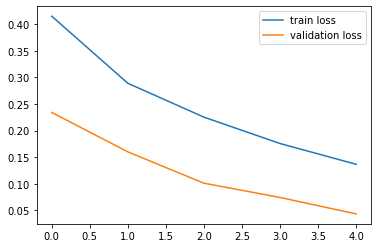

In [28]:
# plot training history
plt.plot(train_history.history['loss'], label='train loss')
plt.plot(train_history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

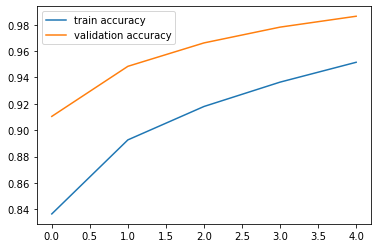

In [29]:
# plot training history
plt.plot(train_history.history['accuracy'], label='train accuracy')
plt.plot(train_history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [30]:
## The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [31]:
print("Number of examples in Test data: {}".format(test_df.shape[0]))

test_df.head()

Number of examples in Test data: 5195


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [32]:
test_input = encode(test_df, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [33]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
# predictions = predictions[:test.shape[0]]

In [34]:
submission = test_df.id.copy().to_frame()
submission['prediction'] = predictions

submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1


In [35]:
submission.to_csv("submission.csv", index = False)